In [5]:
import pandas
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pathToDataset = "../../Twitter-Absolute-Sigma-500.csv"
data = pandas.read_csv(pathToDataset, sep=",",encoding="utf8",index_col=0)


Retirer des données à étudier la dernière colonne correspondant au résultat (buzz ou pas buzz)

In [6]:
df = data.iloc[:, :76]
print(df.shape)
df.head(n=5)

(140707, 76)


,NCD_1,NCD_2,NCD_3,NCD_4,NCD_5,NCD_6,AI_0,AI_1,AI_2,AI_3,...,ADL_4,ADL_5,ADL_6,NAD_0,NAD_1,NAD_2,NAD_3,NAD_4,NAD_5,NAD_6
NCD_0,,,,,,,,,,,,,,,,,,,,,
889,939,960,805,805,1143,1121,549,613,587,447,...,1,1,1,889,939,960,805,805,1143,1121
542,473,504,626,647,795,832,366,288,318,445,...,1,1,1,542,473,504,626,647,795,832
92,99,196,100,184,79,162,66,59,118,58,...,1,1,1,92,99,196,100,184,79,162
90,87,92,344,184,848,184,83,78,76,288,...,1,1,1,90,87,92,344,184,848,184
169,98,101,90,96,95,185,141,68,85,73,...,1,1,1,169,98,101,90,96,95,185


# Choix du nombre d'axes à retenir

Pour le choix des axes principaux, on applique le critère de Kaiser.
Ce qui veut dire qu'on ne garde que les composantes principales d'inertie expliquée supérieure à 1

In [7]:
pca = PCA(n_components = 20)
pca.fit((df - df.mean()) / df.std())
np.sort(pca.explained_variance_)


array([  1.54749966e-02,   1.78984939e-02,   2.33201736e-02,
         2.91416183e-02,   1.09266168e-01,   1.61343900e-01,
         2.12006330e-01,   2.18741299e-01,   3.34607252e-01,
         3.79912487e-01,   4.05605107e-01,   4.77854699e-01,
         5.58693674e-01,   6.09379102e-01,   6.28036529e-01,
         9.14108300e-01,   9.58792397e-01,   1.18460322e+00,
         2.79592273e+00,   3.09114497e+01])

Nous en déduisons que le nombre d'axes est donc égal à 13

In [8]:
pca = PCA(n_components = 13)
pca.fit((df - df.mean()) / df.std())
print("la part d'inertie expliquée avec les 13 composantes : ",sum(pca.explained_variance_ratio_))


la part d'inertie expliquée avec les 13 composantes :  0.913379201969


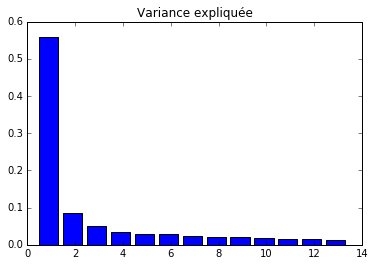

In [10]:
%matplotlib inline
plt.bar(np.arange(len(pca.explained_variance_ratio_))+0.5, pca.explained_variance_ratio_)
plt.title("Variance expliquée")

In [11]:
X_reduced = pca.transform(df)
#i = np.identity(df.shape[1])
#coef = pca.transform(i)
#coef
#X_reduced_df = pandas.DataFrame(X_reduced)
#X_reduced_df.head(n=5)